In [1]:
from dxfwrite import DXFEngine as dxf
import numpy as np
import matplotlib.pyplot as plt
import microfluidics as mf
#import pyclipper
from copy import deepcopy

In [2]:
#give the name of the dxf file to write
file_name = '/Users/guillaume/Google Drive/PostDocBasel/PyMicrofluidics/3layerMoM_py_b.dxf'

#Each layer is defined as a dictionary that is itself stored in a dictionary with a useful name. Each layer dictionary
#has the following fields
#name: layer name stored in DXF file
#color: color assigned to layer
#inversion: 0 == nothing happens, 1 == the layer is rotated 180° on the wafer (for multilayers)
layers = {'layer_deep':{'name':'layer_6um','color':1, 'inversion':0},
          'layer_growth':{'name':'layer_900nm','color':2, 'inversion':0},
          'layer_shallow':{'name':'layer_200nm','color':3, 'inversion':0},
          'layer_sizeref':{'name':'size_ref','color':4, 'inversion':0}}

In [3]:
#where to move the complete design
origins = [np.array([-25000,0]),np.array([-25000,-20000]),np.array([-25000,20000])]
#gc_widht is a list of growth channel widths in um
widths_GC = [0.8,0.8,1.0,1.0,1.1,1.1]

In [4]:
#define position of all the features. Here the [0,0] position is at the dial-awawe
#radius of large channels
lc_rad = 25
#positions relative to origin
pos_inlet = np.array([-2100,-2600])
#left and right x limit of channel features (except OF)
leftlim = 700
rightlim = 11670

#inlet
x_inlet = -2300
y_inlet = -2600
#dial-awawe
separation = 10#separation between OF channels and channel leading to serpentine
#serpentine
x_serpentine_start = 1000
y_serpentine_start = -500
#BF outlet 
x_outlet_BF = 19500
#CF outlet 
x_outlet_CF = 15500
#OF outlet 
x_outlet_OF = 23500

#OF at dial-awawe
y_dial_OF = -1.5*lc_rad-separation
#OF main distance
y_main_OF = -3400
#BF main y distance
y_main_BF1 = -2500
y_main_BF2 = -1740
y_main_BF3 = -1150

#CF main y distance
y_main_CF1 = y_main_BF1+120
y_main_CF2 = y_main_CF1+280
y_main_CF3 = y_main_BF3+120
y_main_CF4 = y_main_CF3+280

#%part of the growth channel overlapping with main channels
overlap_GC = 3

In [5]:
#growth channel parameters
length_GC = 40;#channel length (including overlapping region)
num_GC = 320;#number of channels per size
space_GC = 5;#space between single channels
space_series_GC = 100;#space between channel series
#pos_channelseries1 = junction+[1000,-2600];%lower left position of growth channel series 1
#pos_channelseries2 = pos_channelseries1+[0,1300];%lower left position of growth channel series 2

In [6]:
#abberviations
#OF == overflow
#CF == channel flow
#BF == back flow
#GC == growth channel
#NL = number layer

In [7]:
#define the paths of all features as well as some special features like channel arrays

#inlet channels
xy_inlet = [[x_inlet, y_inlet],[-100,-lc_rad-separation],[0,-lc_rad-separation]]
curv_inlet = [0,50,0]

#dial-awawe to serpentine
xy_dial_serpentine = [[0,0],[460,0],[x_serpentine_start-100,y_serpentine_start],[x_serpentine_start,y_serpentine_start]]
curv_dial_serpentine = [0,50,50,0]

#serpentine
serpentine = mf.serpentine(7, 150, lc_rad, 10000,75,[x_serpentine_start,y_serpentine_start],'left','bottom', 'horizontal')

#serpentine to CF
xy_serpentine_to_CF = [[x_serpentine_start+10000,y_serpentine_start+(7-1)*150],[x_serpentine_start+10000+300,y_serpentine_start+(7-1)*150],
                      [np.max(serpentine)+300,0],[rightlim-200,0]]
curv_serpentine_to_CF = [0,50,50,0]

#overflow channel
xy_OF = [(0,y_dial_OF),(100,y_dial_OF),(300,-300),(300,y_main_OF),(x_outlet_OF,y_main_OF),(x_outlet_OF,0)]
curv_OF = [0,50,50,50,50,0]
rad_OF = 12.5

#back flow channel
xy_BF = [(x_outlet_BF,0),(x_outlet_BF,y_main_BF1),(leftlim,y_main_BF1),(leftlim,y_main_BF2),
         (rightlim-260,y_main_BF2),(rightlim-260,y_main_BF3),(leftlim,y_main_BF3)]
curv_BF = [0,50,50,50,50,50,0]
rad_BF = lc_rad

#regular flow channel
xy_CF = [(x_outlet_CF,0),(rightlim,y_main_CF1),(leftlim+100,y_main_CF1),(leftlim+100,y_main_CF2),
         (rightlim,y_main_CF2),(rightlim,y_main_CF3),(leftlim+100,y_main_CF3),(leftlim+100,y_main_CF4),
        (rightlim,y_main_CF4),(rightlim,-100),(rightlim-100,0),(rightlim-200,0)]
curv_CF = [0,50,50,50,50,50,50,50,50,50,50,0]
rad_CF = lc_rad

#global filter shape
xy_filter = [(leftlim, y_main_BF3-lc_rad),(leftlim,y_main_CF4),(leftlim+100,y_main_CF4)]
curv_filter = [0,25,0]
rad_filter = 25

#growith channels
GC_1 = mf.channel_array(length_GC, num_GC, space_GC, space_series_GC, widths_GC, 
                         [leftlim+300,y_main_CF1-lc_rad+overlap_GC],1)
GC_2 = mf.channel_array(length_GC, num_GC, space_GC, space_series_GC, widths_GC, 
                        [leftlim+300,y_main_CF3-lc_rad+overlap_GC],1)

#challow comb structure at the end of growth channels  
rad_comb = 0.5
comb_long_1 = mf.define_tube([[np.min(GC_1[0][:,0])-2,np.min(GC_1[0][:,1])+rad_comb+2],[np.max(GC_1[-1][:,0])+2,np.min(GC_1[0][:,1])+rad_comb+2]],
                                               [0,0],rad_comb)
comb_long_2 = mf.define_tube([[np.min(GC_2[0][:,0])-2,np.min(GC_2[0][:,1])+rad_comb+2],[np.max(GC_2[-1][:,0])+2,np.min(GC_2[0][:,1])+rad_comb+2]],
                                               [0,0],rad_comb)
comb_teeth_1 = mf.channel_array(10, num_GC, space_GC, space_series_GC, [1 for i in range(len(widths_GC))], 
                         [leftlim+300+0.5*space_GC,np.min(GC_1[0][:,1])+2],1)
comb_teeth_2 = mf.channel_array(10, num_GC, space_GC, space_series_GC, [1 for i in range(len(widths_GC))], 
                         [leftlim+300+0.5*space_GC,np.min(GC_2[0][:,1])+2],1)



In [8]:
#create layer with numbers and supporting pillars
miny_comb = np.min(comb_teeth_1[0][:,1])
y_NL = y_main_BF1+0.5*(np.abs((miny_comb-y_main_BF1))+lc_rad)
rad_NL = (miny_comb-y_main_BF1-lc_rad)/2+3
NL_back_1 = mf.define_tube([[np.min(comb_teeth_1[0][:,0])-20,y_NL],[np.max(comb_teeth_1[-1][:,0])+20,y_NL]],[0,0],rad_NL)

num_array = mf.number_array(5, num_GC, space_GC, space_series_GC, len(widths_GC), 
                         [leftlim+300,y_NL],10, rotation = -np.pi/2)

support_len = 20
support_array = mf.channel_array(support_len, num_GC, space_GC, space_series_GC, [2 for i in range(len(widths_GC))],
                                 [leftlim+300+0.5*space_GC,y_NL+support_len/2],2)
support_array = [support_array[x] for x in range(len(support_array)) if np.mod(x+0,5)*np.mod(x,5)!=0] 

features_to_invert = []
features_to_invert = features_to_invert+num_array
features_to_invert = features_to_invert+support_array
num_pad = mf.reverse_feature(features_to_invert,NL_back_1)

#copy this number layer at each location of channel arrays (don't use mirroring as it flips numbers)
num_pad2 = num_pad.copy()
for x in range(len(num_pad2)):
    num_pad2[x] = np.array([y + np.array([0,y_main_BF3-y_main_BF1]) for y in num_pad2[x]])
    
num_pad3 = num_pad.copy()
y_target = -y_NL + (-y_main_BF1) - lc_rad -rad_NL+3
for x in range(len(num_pad2)):
    num_pad3[x] = np.array([y + np.array([0,y_target]) for y in num_pad3[x]])
    
num_pad4 = num_pad.copy()
y_target = -y_NL + (-y_main_BF3) - lc_rad -rad_NL+3
for x in range(len(num_pad2)):
    num_pad4[x] = np.array([y + np.array([0,y_target]) for y in num_pad4[x]])

KeyboardInterrupt: 

In [10]:
#design is a dictionnary of features to draw. Each feature is itself a dictionary entry with a freely chosen name and 
#that has the following content:
#1. 'coord': either a 2D numpy array or a list of 2D numpy arrays
#2. 'layer': a dictionnary e.g. {'name':'layer_6um','color':1, 'inversion':0}
#3. 'mirror': an optional field that gives the position of the horizontal axis around which to mirror the feature
design = {}
design['inlet_channel'] = {'coord': mf.define_tube(xy_inlet,curv_inlet,lc_rad), 'layer': layers['layer_deep'],'mirror': 0}
design['over_flow'] = {'coord': mf.define_tube(xy_OF,curv_OF,rad_OF), 'layer': layers['layer_deep'],'mirror': 0}
design['back_flow'] = {'coord': mf.define_tube(xy_BF,curv_BF,rad_BF), 'layer': layers['layer_deep'],'mirror': 0}
design['channel_flow'] = {'coord': mf.define_tube(xy_CF,curv_CF,rad_CF), 'layer': layers['layer_deep'],'mirror': 0}
design['serpentine'] = {'coord': mf.serpentine(7, 150, lc_rad, 10000,75,[x_serpentine_start,y_serpentine_start], 'left','bottom', 'horizontal'), 'layer': layers['layer_deep']}
design['dial_to_serpentine'] = {'coord': mf.define_tube(xy_dial_serpentine,curv_dial_serpentine,lc_rad), 'layer': layers['layer_deep']}
design['serpentine_to_CF'] = {'coord': mf.define_tube(xy_serpentine_to_CF,curv_serpentine_to_CF,lc_rad), 'layer': layers['layer_deep']}

design['punching_entry'] = {'coord': mf.circular_punching(20,250,[x_inlet,y_inlet]), 'layer': layers['layer_deep'],'mirror': 0}
design['punching_BF'] = {'coord': mf.circular_punching(20,250,[x_outlet_BF,0]), 'layer': layers['layer_deep']}
design['punching_OF'] = {'coord': mf.circular_punching(20,250,[x_outlet_OF,0]), 'layer': layers['layer_deep']}
design['punching_CF'] = {'coord': mf.circular_punching(20,250,[x_outlet_CF,0]), 'layer': layers['layer_deep']}

design['growth_channel_1'] = {'coord': GC_1, 'layer': layers['layer_growth'],'mirror': 0}
design['growth_channel_2'] = {'coord': GC_2, 'layer': layers['layer_growth'],'mirror': 0}

design['filter'] = {'coord': mf.patterned_region(mf.define_tube(xy_filter,curv_filter,rad_filter),1,7),'layer': layers['layer_shallow'],'mirror': 0}

design['comb_long1'] = {'coord': comb_long_1, 'layer': layers['layer_shallow'],'mirror': 0}
design['comb_long2'] = {'coord': comb_long_2, 'layer': layers['layer_shallow'],'mirror': 0}
design['comb_teeth_1'] = {'coord': comb_teeth_1, 'layer': layers['layer_shallow'],'mirror': 0}
design['comb_teeth_2'] = {'coord': comb_teeth_2, 'layer': layers['layer_shallow'],'mirror': 0}

align, align2 = mf.align_mark_squares(pos = [leftlim+1000,y_main_OF-1000])
design['align_mark1'] = {'coord': align, 'layer': layers['layer_shallow']}
design['align_mark1b'] = {'coord': align2, 'layer': layers['layer_growth']}
align, align2 = mf.align_mark_squares(pos = [leftlim+5000,y_main_OF-1000],rotation=True)
design['align_mark2'] = {'coord': align, 'layer': layers['layer_shallow']}
design['align_mark2b'] = {'coord': align2, 'layer': layers['layer_deep']}

design['numbers'] = {'coord': num_array, 'layer': layers['layer_growth']}

#design['numbers'] = {'coord': num_pad, 'layer': layers['layer_growth']}
#design['numbers2'] = {'coord': num_pad2, 'layer': layers['layer_growth']}
#design['numbers3'] = {'coord': num_pad3, 'layer': layers['layer_growth']}
#design['numbers4'] = {'coord': num_pad4, 'layer': layers['layer_growth']}


In [11]:
#open drawing
drawing = dxf.drawing(file_name)
#define all layers
for x in layers:
    drawing.add_layer(layers[x]['name'], color=layers[x]['color'])

#add design at all positions defined by origins 
#!!!!!!!!!!!!VERY IMPORTANT!!!!!!!!!!
#(I use deepcopy here to be able to copy the same design several times)
#!!!!!!!!!!!!VERY IMPORTANT!!!!!!!!!!
for x in origins:
    design_adjusted = mf.set_design_origin(deepcopy(design),x)
    mf.draw_design(design_adjusted,drawing)

#complete design with global alignement marks
align, align2 = mf.align_mark_squares(pos = [-40000,1000])
drawing = mf.add_closed_polyline(layers['layer_shallow'],align,drawing)
drawing = mf.add_closed_polyline(layers['layer_growth'],align2,drawing)

align, align2 = mf.align_mark_squares(pos = [-40000,5000],rotation=True)
drawing = mf.add_closed_polyline(layers['layer_shallow'],align,drawing)
drawing = mf.add_closed_polyline(layers['layer_deep'],align2,drawing)

align, align2 = mf.align_mark_squares(pos = [40000,-3000])
drawing = mf.add_closed_polyline(layers['layer_shallow'],align,drawing)
drawing = mf.add_closed_polyline(layers['layer_growth'],align2,drawing)

align, align2 = mf.align_mark_squares(pos = [40000,-5000],rotation=True)
drawing = mf.add_closed_polyline(layers['layer_shallow'],align,drawing)
drawing = mf.add_closed_polyline(layers['layer_deep'],align2,drawing)

drawing.save()

If you want to directly draw some of the features in this notebook, just to have a look at them, you can use the following code

In [13]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

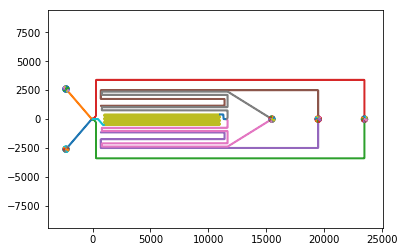

In [44]:
features_to_plot = ['inlet_channel','over_flow','back_flow','channel_flow','serpentine','punching_entry',
                   'punching_BF','punching_OF','punching_CF','dial_to_serpentine','serpentine_to_CF']
for elem in features_to_plot:
    if type(design[elem]['coord']) is not list:
            toplot = [design[elem]['coord']]
    else:
        toplot = design[elem]['coord']
    for tp in toplot:
        plt.plot(tp[:,0], tp[:,1])
        if 'mirror' in design[elem]:
            flipped = mf.flip_feature(tp,0)
            plt.plot(flipped[:,0], flipped[:,1])
plt.axis('equal')
plt.show()
